In [1]:
# 라이브러리를 불러옵니다.
import numpy as np
import pandas as pd
from itertools import combinations
from collections import Counter

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

import networkx as nx

In [2]:
# 데이터를 불러옵니다.
data = pd.read_csv('./data/anti_depressant_prescription_all_meds.csv')

In [3]:
# 데이터의 첫 다섯 줄을 출력합니다.
print(data.shape)
data.head()

(704202, 15)


,기준년도,가입자일련번호,처방내역일련번호,일련번호,성별코드,연령대코드(5세단위),시도코드,요양개시일자,약품일반성분명코드,1회 투약량,1일투약량,총투여일수,단가,금액,데이터 공개일자
0,2017,62,7819529,1,1,12,41,20170711,142902ATB,2.0,1,28,23.0,1288,20181126
1,2017,62,7819529,2,1,12,41,20170711,242901ATB,2.0,1,28,40.0,2240,20181126
2,2017,62,35429246,1,1,12,41,20170808,142902ATB,2.0,1,28,23.0,1288,20181126
3,2017,62,35429246,2,1,12,41,20170808,242901ATB,2.0,1,28,40.0,2240,20181126
4,2017,62,37765102,1,1,12,41,20170609,454002ATB,1.0,1,90,686.0,61740,20181126


---

### 약품일반성분명코드란?
**약품일반성분명코드** 또는 **주성분코드**는 의약품의 대표하는 성분에 대한 코드입니다. \
총 9자리로 구성되어 있으며 구성은 아래와 같습니다. 앞 4자리의 주성분 일련번호가 동일하면 동일한 성분으로 생각할 수 있습니다.

![주성분코드](img/주성분코드.png)

이후로는 Main Ingredient Code (MI_code)라고 지칭하도록 하겠습니다.

In [4]:
# 자주 사용할 컬럼의 이름을 바꿔줍니다.
data.rename(columns={'가입자일련번호': 'uid',  # user id
                     '처방내역일련번호': 'pid',  # prescription id
                     '연령대코드(5세단위)': 'age_group',  # age group
                     '약품일반성분명코드': 'mi_code'}, inplace=True)

In [5]:
# 한 환자당 처방전의 개수를 세어봅니다.
data.groupby(['uid', 'pid'])['pid'].count().describe()

count    143008.000000
mean          4.924214
std           2.538707
min           1.000000
25%           3.000000
50%           5.000000
75%           6.000000
max          30.000000
Name: pid, dtype: float64

#### 각 나이대별 처방전은 몇개의 약물을 포함하고 있을까?

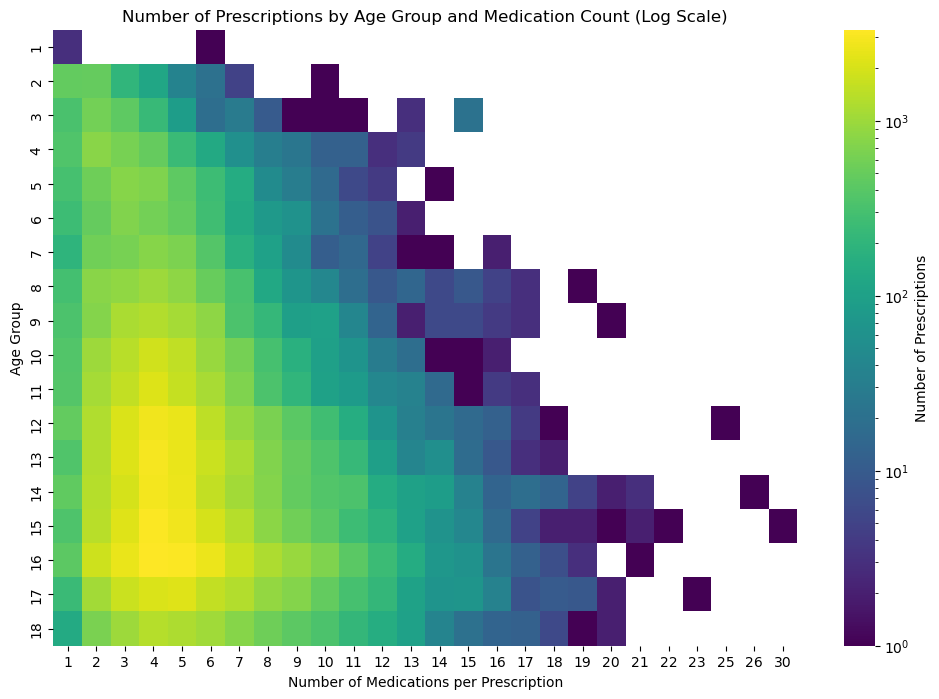

In [6]:
# Step 1: Calculate the number of medications per prescription for each age group
grouped = data.groupby(['age_group', 'pid'])['mi_code'].count().reset_index()
grouped.rename(columns={'mi_code': 'cnt_med'}, inplace=True)

# Step 2: Count the number of prescriptions for each age group and medication count
counts = grouped.groupby(['age_group', 'cnt_med']).size().reset_index(name='cnt_pres')

# Step 3: Pivot the data to create a matrix suitable for a heatmap
pivot_table = counts.pivot(index='age_group', columns='cnt_med', values='cnt_pres').fillna(0)

# Step 4: Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, norm=LogNorm(), cmap='viridis', cbar_kws={'label': 'Number of Prescriptions'})
plt.xlabel('Number of Medications per Prescription')
plt.ylabel('Age Group')
plt.title('Number of Prescriptions by Age Group and Medication Count (Log Scale)')
plt.show()

처방전 별 평균 약품 수는 연령대 그룹이 올라갈수록 높아지는 트렌드를 보여주고 있습니다.

그러나 많은 처방전들이 4~6 사이의 약품을 처방한다는 것을 확인할 수 있습니다.

한 사람당 여러번의 처방전이 발부될 수 있고 (max 30개), 그 처방전들 중 같은 약을 포함하기도하고 다른 약을 포함하기도 한다는 것을 볼 수 있습니다.

두 종류의 약물이 같이 처방된 빈도 수를 계산할 때, 같은 사람에게 여러번 처방된 케이스는 같이 처방된 횟수로 나누어야 한다고 판단했습니다.

그렇지 않으면 한사람에게 여러번 처방된 약들이 weight에 불평등한 영향을 미칠 것으로 예상됩니다.

---

In [7]:
data.head()

,기준년도,uid,pid,일련번호,성별코드,age_group,시도코드,요양개시일자,mi_code,1회 투약량,1일투약량,총투여일수,단가,금액,데이터 공개일자
0,2017,62,7819529,1,1,12,41,20170711,142902ATB,2.0,1,28,23.0,1288,20181126
1,2017,62,7819529,2,1,12,41,20170711,242901ATB,2.0,1,28,40.0,2240,20181126
2,2017,62,35429246,1,1,12,41,20170808,142902ATB,2.0,1,28,23.0,1288,20181126
3,2017,62,35429246,2,1,12,41,20170808,242901ATB,2.0,1,28,40.0,2240,20181126
4,2017,62,37765102,1,1,12,41,20170609,454002ATB,1.0,1,90,686.0,61740,20181126


### 주성분명 및 ATC코드 매핑

In [8]:
# 주성분코드 - 주성분 매핑
mi_code_mapping = pd.read_csv('./data/mapping.csv')

# 주성분코드를 이름으로 바꿔줍니다.
df = data.merge(mi_code_mapping, left_on='mi_code', right_on='주성분코드', how='left')

In [9]:
# 매핑된 데이터와 매핑되지 않은 데이터를 나눠줍니다.
mapped_df = df[df['주성분명'].notnull()]
unmapped_df = df[df['주성분명'].isnull()]

# 매핑이 안 된 주성분코드의 개수를 세어봅니다.
print("매핑되지 않은 주성분코드 개수:", len(unmapped_df['mi_code'].unique()))

# 처방전 개수가 가장 많은 매핑되지 않은 주성분코드를 찾습니다.
unmapped_counts = unmapped_df['mi_code'].value_counts()
unmapped_counts.head(10)

매핑되지 않은 주성분코드 개수: 54


mi_code
478601ACS    1126
199404ATE    1004
189001ACH     356
430301ACH     329
172701ACH     324
233303ACS     121
233001ACS      62
232301ASS      58
242307ATR      52
146530ASS      44
Name: count, dtype: int64

매핑이 되지 않은 약품들은 급여약품이 아닌 것으로 추정됩니다. 

---

## 시각화용 Pajek 네트워크 만들기
- 목표: Pajek 파일을 만들기 위한 데이터를 준비합니다.

- 형태: (처방전 ID, 약품 일반 성분 코드)의 리스트 - Bipartite Network


In [10]:
mapped_df.head()

,기준년도,uid,pid,일련번호,성별코드,age_group,시도코드,요양개시일자,mi_code,1회 투약량,1일투약량,총투여일수,단가,금액,데이터 공개일자,주성분코드,ATC코드,주성분명
0,2017,62,7819529,1,1,12,41,20170711,142902ATB,2.0,1,28,23.0,1288,20181126,142902ATB,N05BA01,diazepam
1,2017,62,7819529,2,1,12,41,20170711,242901ATB,2.0,1,28,40.0,2240,20181126,242901ATB,N06AX05,trazodone
2,2017,62,35429246,1,1,12,41,20170808,142902ATB,2.0,1,28,23.0,1288,20181126,142902ATB,N05BA01,diazepam
3,2017,62,35429246,2,1,12,41,20170808,242901ATB,2.0,1,28,40.0,2240,20181126,242901ATB,N06AX05,trazodone
4,2017,62,37765102,1,1,12,41,20170609,454002ATB,1.0,1,90,686.0,61740,20181126,454002ATB,C10AA07,rosuvastatin


In [11]:
# 'pid'와 '주성분명' 열만 추출합니다.
pid_drug_df = mapped_df[['pid', '주성분명']]

# 고유한 'pid'와 '주성분명'의 리스트 생성
unique_pids = pid_drug_df['pid'].unique()
unique_drugs = pid_drug_df['주성분명'].unique()

# 'pid'와 '주성분명'에 노드 번호 할당
pid_to_node = {pid: idx + 1 for idx, pid in enumerate(unique_pids)}  # 'pid' 노드는 1부터 시작
drug_to_node = {drug: idx + 1 + len(unique_pids) for idx, drug in enumerate(unique_drugs)}  # '주성분명' 노드

# 전체 노드 수 계산
M = len(unique_pids)
N = M + len(unique_drugs)

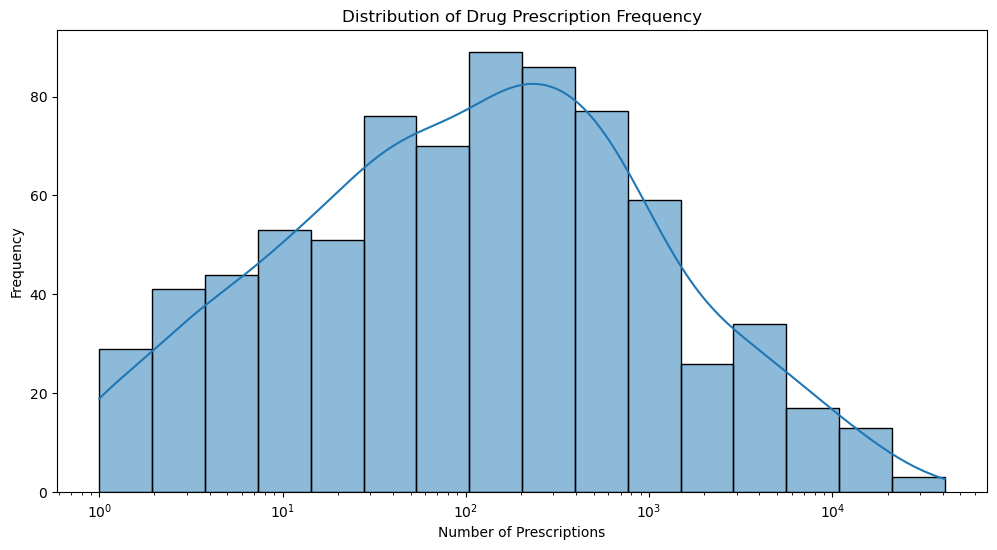

In [12]:
# "주성분명" 별로 몇번 처방되었는지 계산합니다.
drug_counts = pid_drug_df['주성분명'].value_counts()

# 처방된 빈도를 시각화합니다.
plt.figure(figsize=(12, 6))
sns.histplot(drug_counts, kde=True, log_scale=True)
plt.xlabel('Number of Prescriptions')
plt.ylabel('Frequency')
plt.title('Distribution of Drug Prescription Frequency')
plt.show()

In [13]:
drug_counts.describe()

count      768.00000
mean       979.58724
std       2998.93769
min          1.00000
25%         21.00000
50%        125.50000
75%        520.25000
max      41050.00000
Name: count, dtype: float64

의미성이 낮은 약물명들을 제거하여 노드 수를 줄이고자 합니다.

N의 기준을 뭐로 잡을지?
- 단순 수치 보다 처방횟수가 낮은 약물들
- 특정 나이 그룹 별 공통 처방 횟수가 높은 약물을 확인

In [14]:
# 엣지 가중치 계산 ('pid'와 '주성분명' 쌍의 발생 횟수)
edge_weights = pid_drug_df.groupby(['pid', '주성분명']).size().reset_index(name='weight')

# 'pid'와 '주성분명'을 노드 번호로 매핑
edge_weights['pid_node'] = edge_weights['pid'].map(pid_to_node)
edge_weights['drug_node'] = edge_weights['주성분명'].map(drug_to_node)

In [ ]:
# Pajek 파일 생성 (UTF-8 인코딩 사용)
with open('prescription_medicine.net', 'w', encoding='utf-8') as f:
    # 노드 작성
    f.write(f'*Vertices {N} {M}\n')
    # 'pid' 노드 작성
    for pid in unique_pids:
        node_id = pid_to_node[pid]
        f.write(f'{node_id} "{pid}"\n')
    # '주성분명' 노드 작성
    for drug in unique_drugs:
        node_id = drug_to_node[drug]
        f.write(f'{node_id} "{drug}"\n')

    # 엣지와 가중치 작성
    f.write('*Edges\n')
    for _, row in edge_weights.iterrows():
        pid_node = row['pid_node']
        drug_node = row['drug_node']
        weight = row['weight']
        f.write(f'{pid_node} {drug_node} {weight}\n')

: 

: 

: 

---

In [15]:
# mi_code의 첫 네자리를 추출하여 새로운 컬럼을 만듭니다.
data['mi_code_4'] = data['mi_code'].astype(str).str[:4]
print(f"고유 주성분코드 개수: {len(data['mi_code'].unique())}")
print(f"고유 주성분 개수: {len(data['mi_code_4'].unique())}")

고유 주성분코드 개수: 1896
고유 주성분 개수: 1070


In [16]:
# view distribution of number of prescriptions per medication
data.groupby('mi_code')['pid'].nunique().describe()

count     1896.000000
mean       367.158228
std       1469.301564
min          1.000000
25%          7.000000
50%         37.000000
75%        176.000000
max      36560.000000
Name: pid, dtype: float64

In [17]:
# filter out medications that are prescribed less than 10 times
med_pres_counts = data['mi_code'].value_counts()
med_pres_counts = med_pres_counts[med_pres_counts >= 100]
data_n = data[data['mi_code'].isin(med_pres_counts.index)]
print(len(data_n['mi_code_4'].unique()))

429


---

In [ ]:
def process_patient_data(patient_groups, full=True):
    # 페어 카운트를 저장할 Counter 초기화
    pair_counts = Counter()
    
    for patient_id, group in patient_groups:
        # 해당 환자의 모든 처방 가져오기
        if full:
            prescriptions = group.groupby('pid')['mi_code'].apply(list)
        else:
            prescriptions = group.groupby('pid')['mi_code_4'].apply(set)
        
        # 해당 환자의 유니크 약물 주성분 페어와 자기 자신 루프를 저장할 집합
        patient_pairs = set()
        patient_self_loops = set()
        
        # 해당 환자에게 처방된 모든 유니크 약물 주성분 페어와 자기 자신 루프 수집
        for meds in prescriptions:
            # 처방 내 각 약물 주성분의 발생 횟수 계산
            med_counts = Counter(meds)
            
            # 한 번 이상 나타나는 약물 주성분 식별 (self-loop)
            for med, count in med_counts.items():
                if count > 1:
                    patient_self_loops.add(med)
            
            # 페어 조합을 위한 처방 내 유니크 약물 주성분 가져오기
            unique_meds_in_prescription = set(meds)
            pairs = combinations(unique_meds_in_prescription, 2)
            patient_pairs.update(pairs)
        
        # 해당 환자의 유니크 페어를 글로벌 페어 카운트에 업데이트
        pair_counts.update(patient_pairs)
        
        # 자기 자신 루프를 글로벌 페어 카운트에 업데이트
        for med in patient_self_loops:
            pair_counts[(med, med)] += 1

    return pair_counts

: 

: 

Adjacency matrix를 만드는 함수를 정의합니다.

- 대각선을 기준으로 대칭
- 같은 성분의 약물이 중복적으로 처방될 경우를 고려 (self-loop)

In [ ]:
def build_adjacency_matrix(pair_counts, med_to_index):
    # 페어 카운트를 사용하여 인접 행렬 채우기
    adj_matrix = np.zeros((len(med_to_index), len(med_to_index)))
    
    for (med1, med2), count in pair_counts.items():
        idx1 = med_to_index[med1]
        idx2 = med_to_index[med2]
        adj_matrix[idx1][idx2] = count
        if med1 != med2:
            adj_matrix[idx2][idx1] = count  # 대칭 페어의 경우
        else:
            adj_matrix[idx1][idx2] = count  # 자기 자신 루프 (대각선 요소)
    
    return adj_matrix

: 

: 

시험용 테스트 데이터를 만들어 함수들이 제대로 작동하는 지 확인해 보겠습니다.

In [ ]:
# 테스트 데이터프레임 생성
test_data = {
    "uid": [1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3], 
    "pid": [101, 101, 101, 201, 201, 202, 202, 202, 301, 301, 301], 
    "mi_code": [1, 2, 3, 2, 1, 1, 2, 3, 1, 1, 1] 
}
df_test = pd.DataFrame(test_data)

# 약품 코드를 인덱스로 매핑
unique_meds = df_test["mi_code"].unique()
med_to_index = {med: idx for idx, med in enumerate(unique_meds)}

# 환자별 그룹화
patient_groups = df_test.groupby('uid')

# 페어 카운트 처리
pair_counts = process_patient_data(patient_groups)

# 인접 행렬 생성
adj_matrix = build_adjacency_matrix(pair_counts, med_to_index)

# 결과 인접 행렬이 올바른지 확인
expected_adj_matrix = np.array([[1., 2., 2.], [2., 0., 2.], [2., 2., 0.]])
assert np.array_equal(adj_matrix, expected_adj_matrix)

: 

: 

이제 실제 데이터에 적용하겠습니다.

In [ ]:
data_sample = data_n.sample(frac=0.1, random_state=42)

: 

: 

In [ ]:
# 약품 코드를 인덱스로 매핑
unique_meds = data_n["mi_code_4"].unique()
med_to_index = {med: idx for idx, med in enumerate(unique_meds)}

# 환자별 그룹화
patient_groups = data_n.groupby('uid')

# 페어 카운트 처리
pair_counts = process_patient_data(patient_groups, full=False)

# 인접 행렬 생성
adj_matrix = build_adjacency_matrix(pair_counts, med_to_index)

# 인접 행렬을 데이터프레임으로 변환
df_adjacency_matrix = pd.DataFrame(adj_matrix, index=unique_meds, columns=unique_meds)

: 

: 

In [ ]:
df_adjacency_matrix.shape

(424, 424)

: 

: 

In [ ]:
# 인접 행렬의 일부만 출력합니다.
df_adjacency_matrix.iloc[:5, :5]

,1429,2429,4540,1599,1110
1429,0.0,57.0,1.0,4.0,54.0
2429,57.0,0.0,3.0,5.0,132.0
4540,1.0,3.0,0.0,4.0,146.0
1599,4.0,5.0,4.0,0.0,2.0
1110,54.0,132.0,146.0,2.0,0.0


: 

: 

In [ ]:
# 주성분 매핑 데이터프레임을 불러옵니다.
df_mapping = pd.read_csv('./data/name_code_mapping.csv')

# 주성분 이름을 약자로 변환한 컬럼을 추가합니다.
df_mapping['주성분약자'] = df_mapping['주성분명'].apply(lambda x: x[:3])

# 주성분 코드를 주성분 이름으로 매핑하는 딕셔너리를 생성합니다.
mi_code_to_abbrev = df_mapping.set_index('주성분코드')['주성분약자'].to_dict()

: 

: 

Tripotassium bismuth 
dicitrate 0.1g
 (as bismuth oxide 40.5mg, 
as potassium 12mg)/
 Sucralfate hydrate
 (as sucrose octasulfate) 
0.102g/
 Ranitidine hydrochloride(as 
ranitidine) 75mg

have the following codes: 271800ATB,  631800ATB

In [ ]:
rows_to_add = [['271800ATB', 'A02BA', 'sucralfate hydrate', 'suc'], ['631800ATB', 'A02BA', 'sucralfate hydrate', 'suc']]
# 데이터프레임에 행을 추가합니다.
df_mapping = pd.concat([df_mapping, pd.DataFrame(rows_to_add, columns=df_mapping.columns)], ignore_index=True)

: 

: 

In [ ]:
df_mapping.head()

,주성분코드,ATC코드,주성분명,주성분약자
0,130830ASY,N05CC01,chloral hydrate,chl
1,130832ASY,N05CC01,chloral hydrate,chl
2,130833ASY,N05CC01,chloral hydrate,chl
3,149203ATB,N05CM,Other hypnotics and sedatives,Oth
4,149204ATB,N05CM,Other hypnotics and sedatives,Oth


: 

: 

## 그래프 시각화
이제 NetworkX를 통해 시각화를 해주도록 하겠습니다.

In [ ]:
df_adj_mat_sample = df_adjacency_matrix.iloc[:400, :400]

: 

: 

In [ ]:
# adjacency matrix를 networkx 그래프로 변환합니다.
G = nx.from_pandas_adjacency(df_adjacency_matrix)

: 

: 

C:\Users\YuHan\AppData\Local\Temp\ipykernel_11384\3550081257.py:17: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=[edge], alpha=edge[2] / max_weight)


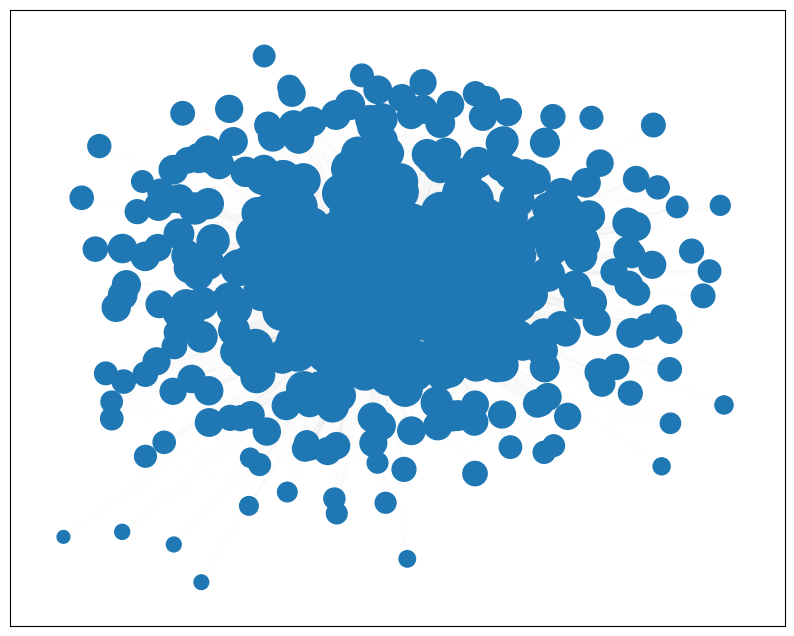

: 

: 

In [ ]:
# 그래프를 그립니다.
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

# 노드의 크기를 degree centrality에 비례하게 설정합니다.
node_size = [G.degree(node) * 3 for node in G.nodes]

# 노드의 색상을 주성분코드에 따라 설정합니다.
index_code = {code: idx for idx, code in enumerate(list(G.nodes))}
node_color_by_abbrev = [index_code[node] for node in G.nodes]
# nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color_by_abbrev, cmap=plt.cm.tab20)
nx.draw_networkx_nodes(G, pos, node_size=node_size)

# 엣지의 투명도를 weight에 비례하게 설정합니다.
max_weight = max([d['weight'] for u, v, d in G.edges(data=True)])
for edge in G.edges(data="weight"):
    nx.draw_networkx_edges(G, pos, edgelist=[edge], alpha=edge[2] / max_weight)

# 인덱스를 이용한 노드 레이블링을 합니다.
# labels = {node: mi_code_to_abbrev[node] for node in G.nodes}
# nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.show()

각 숫자를 해당하는 주성분에 매핑해주도록 하겠습니다.

C:\Users\YuHan\AppData\Local\Temp\ipykernel_11384\2479685509.py:5: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=[edge], alpha=edge[2] / max_weight)


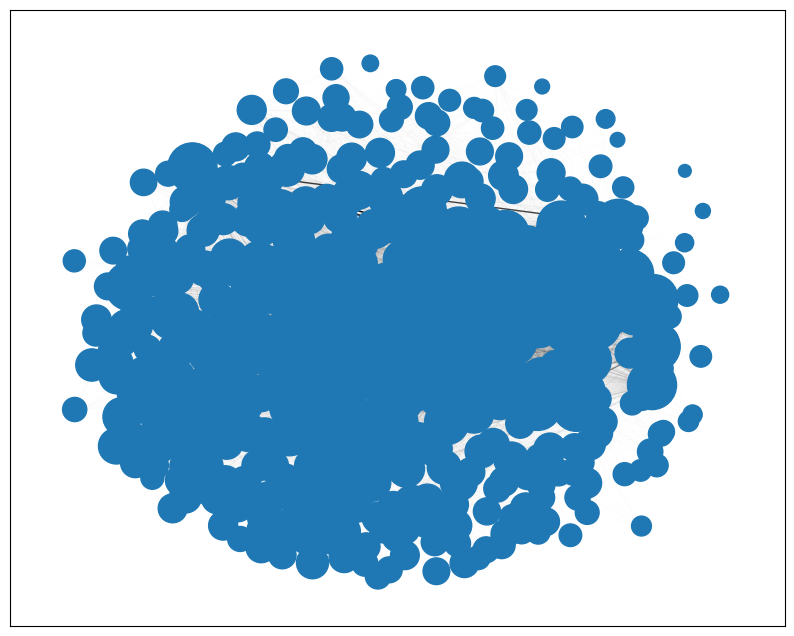

: 

: 

In [ ]:
plt.figure(figsize=(10, 8))
pos = nx.kamada_kawai_layout(G) #positions for all nodes

for edge in G.edges(data="weight"):
    nx.draw_networkx_edges(G, pos, edgelist=[edge], alpha=edge[2] / max_weight)

nx.draw_networkx_nodes(G, pos, node_size=node_size)
plt.show()

C:\Users\YuHan\AppData\Local\Temp\ipykernel_15656\4200247507.py:4: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=[edge], alpha=edge[2] / max_weight)


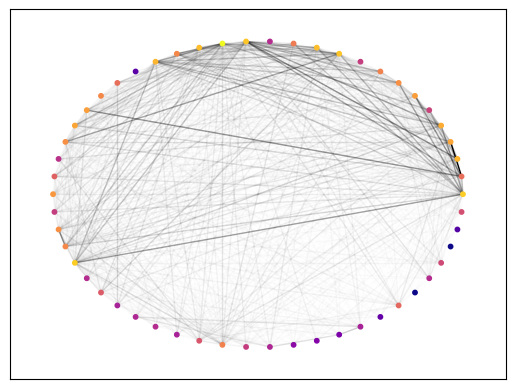

: 

: 

In [ ]:
pos = nx.circular_layout(G) #positions for all nodes

for edge in G.edges(data="weight"):
    nx.draw_networkx_edges(G, pos, edgelist=[edge], alpha=edge[2] / max_weight)

nx.draw_networkx_nodes(G, pos, node_size=10, node_color=node_color, cmap=plt.cm.plasma)

: 

: 